# Leukamia using wrskc

In [1]:
library("evaluomeR")
library("cancerclass")
library("devtools")
library("dplyr")
library("caret")
library("ggplot2")
library("ggrepel")
library("ggforce")
#devtools::install_github("brodsa/wrsk")
library("wrsk")

options(scipen=10)
options(repr.plot.width=12, repr.plot.height=12)

Cargando paquete requerido: SummarizedExperiment

Cargando paquete requerido: MatrixGenerics

Cargando paquete requerido: matrixStats


Adjuntando el paquete: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles,

In [2]:
getRversion()
packageVersion("wrsk")

[1] '4.4.1'

[1] '0.1.0'

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
data("golub")
dataset = golub
colnames(dataset)[colnames(dataset) == 'Case'] <- 'Description'
dataset$Description <- gsub("AML", "M", golub$Description)
head(dataset)
dataset["Class"] = NULL

,Description,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,⋯,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,⋯,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
2,T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,⋯,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
3,T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,⋯,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
4,B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,⋯,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
5,B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,⋯,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
6,T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,⋯,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


In [4]:
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
gold_standard_vector = as.vector(unlist(lapply(golub["Class"], map_strings_to_numbers)))
gold_standard_vector

[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3

Three types of classes within the dataset: **B**, **T** and **M**.

# WRSK <a class="anchor" id="wrsk"></a>
Execution of WRSK over the previous dataset.

In [5]:
k.range = c(3,10)
s = 7.24137931034483
gap_stats = as.numeric(length(k.range[1]:k.range[2]))

In [6]:
calculate_wbcss = function(data, k, s, alpha) {
    set.seed(13606)
    #result = suppressWarnings(wrsk(data, k, s, iteration = 15, cutoff = alpha))
    result = suppressWarnings(wrsk(data, k, s, iteration = 15))
    return(sum(result$WBCSS))
}

calculate_gap_statistic = function(data, k.range, s, alpha) {
    wbcss_values = numeric(length(k.range[1]:k.range[2]))
    wbcss_ref_values = numeric(length(k.range[1]:k.range[2]))
    
    for (k in k.range[1]:k.range[2]) {
        # Calculate WBCSS for original data
        wbcss_values[k - k.range[1] + 1] = calculate_wbcss(data, k, s, alpha)
        
        # Permute the data and calculate WBCSS for the permuted dataset
        permuted_data = data[sample(nrow(data)), ]
        wbcss_ref_values[k - k.range[1] + 1] = calculate_wbcss(permuted_data, k, s, alpha)
    }
    
    # Compute Gap Statistic (log(WBCSS_ref) - log(WBCSS))
    gap_stat = log(wbcss_ref_values) - log(wbcss_values)
    
    return(gap_stat)
}

find_optimal_k = function(gap_stat, k.range) {
  optimal_k_index = which.max(gap_stat)
  optimal_k = (k.range[1]:k.range[2])[optimal_k_index]
  return(optimal_k)
}

In [7]:
dataset_matrix = as.matrix(dataset[, -1])
gap_stat = calculate_gap_statistic(dataset_matrix, k.range, s, alpha)

# Gap stat per k...
print(gap_stat)
#[1]  0.00000000  0.00000000  0.00000000  0.06521775  0.03703765  0.02041107
#[7] -0.03459486 -0.12118547

[1]  0.00000000  0.00000000  0.00000000  0.06521775  0.03703765  0.02041107
[7] -0.03459486 -0.12118547


In [8]:
# Find the optimal k
optimal_k = as.numeric(find_optimal_k(gap_stat, k.range))
print(paste("The optimal k is:", optimal_k))

[1] "The optimal k is: 6"


In [9]:
set.seed(13606)
result = suppressWarnings(wrsk(dataset_matrix, optimal_k, s, iteration = 15))
predicted = result$clusters

In [10]:
dataset["Cluster"] = as.factor(as.numeric(predicted))
pca_matrix <- dataset[, !names(dataset) %in% "Cluster"]
r_pca = evaluomeR::performPCA(dataset = pca_matrix)
pca_df = r_pca$dataset_ncp
pca_df$Cluster <- as.factor(dataset$Cluster)
pca_df$Description <- dataset$Description

Parameter 'npc' is null. Computing number of factors automatically:

Number of factors, 'ncp' used is: 19



In [11]:
# Creating shapes for individuals
pca_df <- pca_df %>%
  mutate(
    # Extract the letter from the Description column
    Letter = substr(Description, 1, 1),
    # Map the letter to a number
    GoldStandard = case_when(
      Letter == "T" ~ 16,
      Letter == "B" ~ 15,
      Letter == "M" ~ 17,
      TRUE ~ NA_real_  # Else...
    )
  )
pca_df$GoldStandard = as.factor(pca_df$GoldStandard)
head(pca_df$GoldStandard)

[1] 15 16 16 15 15 16
Levels: 15 16 17

Warning message:
"ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


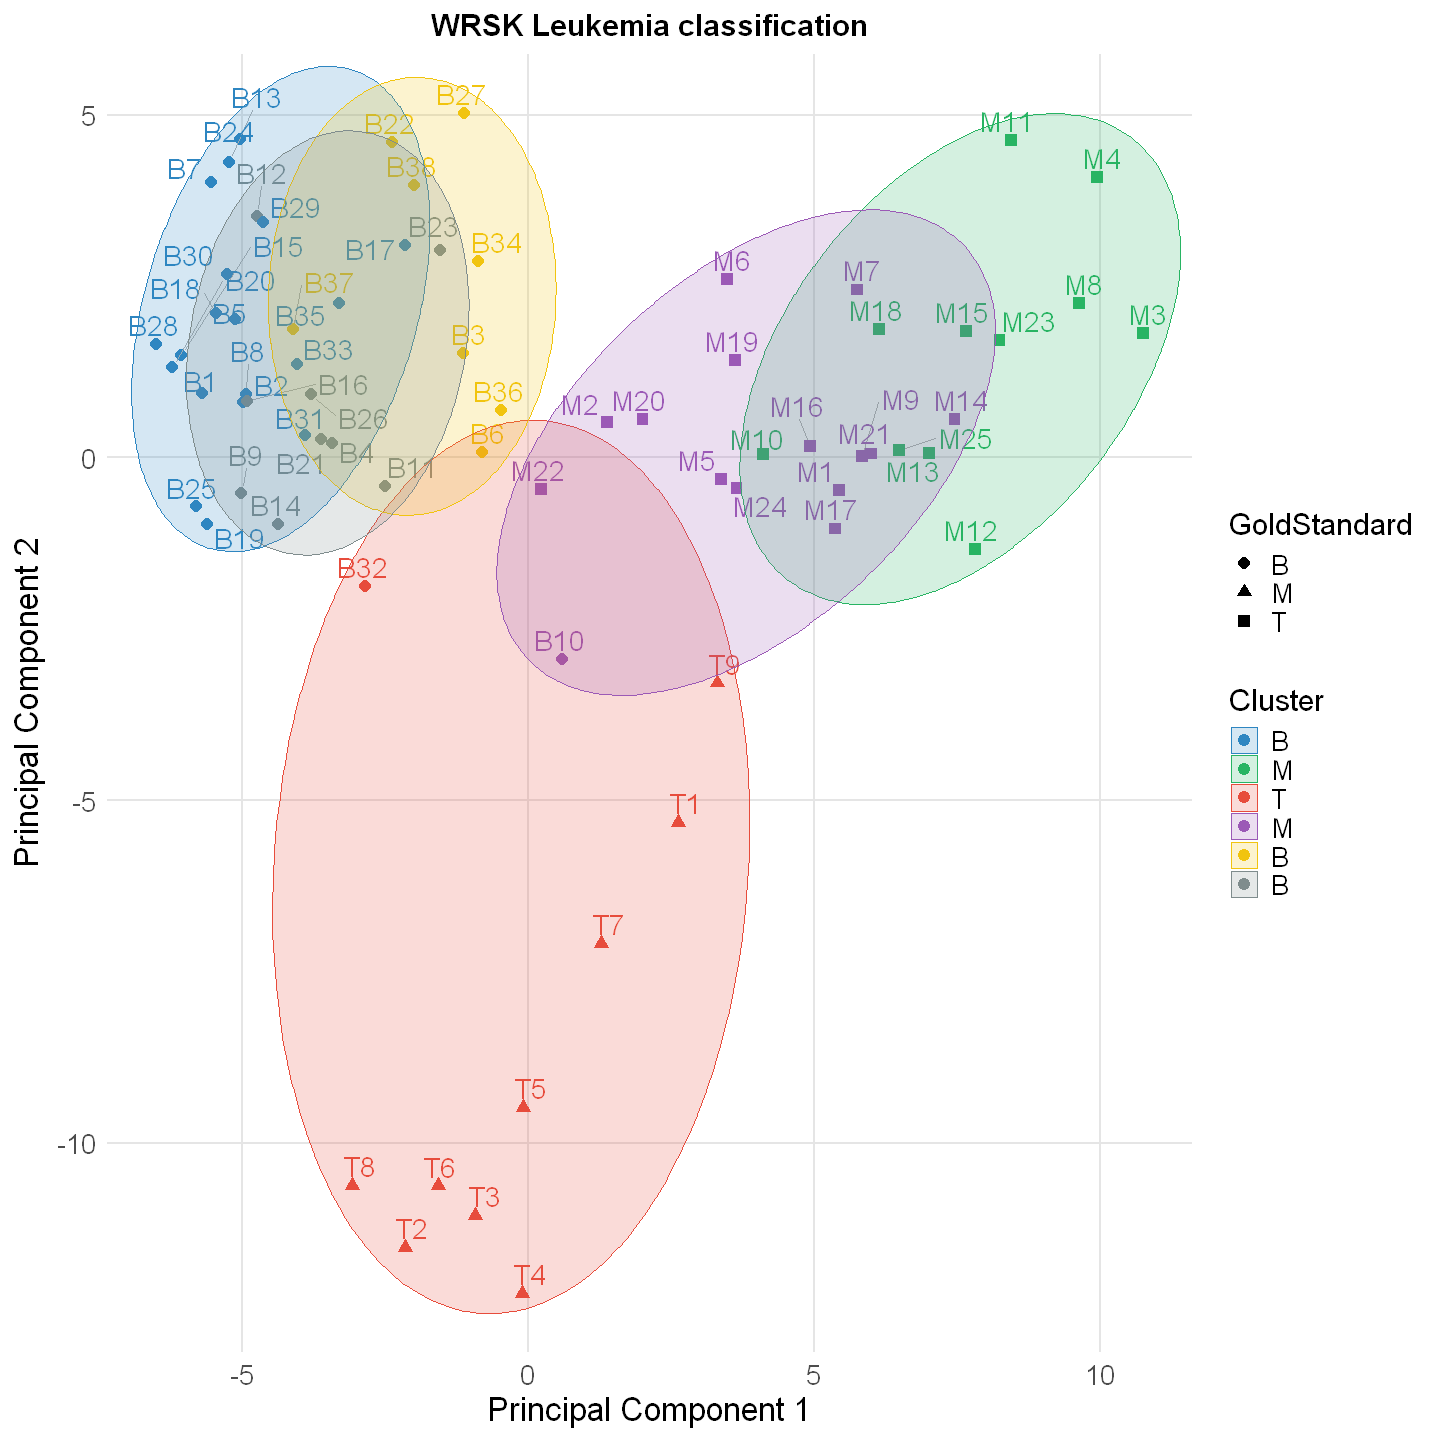

In [12]:
cluster_colors = c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes = c(16, 17, 15)
cluster_labels = c("B", "M", "T", "M", "B", "B")

ggplot(pca_df, aes(x = Dim.1, y = Dim.2, shape = GoldStandard, color = Cluster, label = Description)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 6,
    show.legend = FALSE,
    point.padding = 0.4,
    box.padding = 0.25,
    max.overlaps = 10,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  geom_mark_ellipse(aes(group = Cluster, fill = Cluster, label = NULL), alpha = 0.2) +
  labs(
    title = "WRSK Leukemia classification",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes, labels = cluster_labels) +
  scale_color_manual(values = cluster_colors, labels = cluster_labels) +
  scale_fill_manual(values = cluster_colors, labels = cluster_labels) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    axis.text = element_text(size = 16),
    legend.position = "right",
    legend.title = element_text(size = 18),
    legend.text = element_text(size = 16),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )

In [13]:
sen = RSKC::Sensitivity(predicted, gold_standard_vector)
sensitivity_table <- sen$prob[1,]
cluster_labels = c("B", "T", "M")
names(sensitivity_table) = cluster_labels
sensitivity_table
paste0("(", paste(unlist(sensitivity_table), collapse = ","), ")")

,B,T,M
,<chr>,<chr>,<chr>
Sensitivity. (%),50,100,56


[1] "(50,100,56)"

In [14]:
cer = CER(predicted, gold_standard_vector)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 25.23%"


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


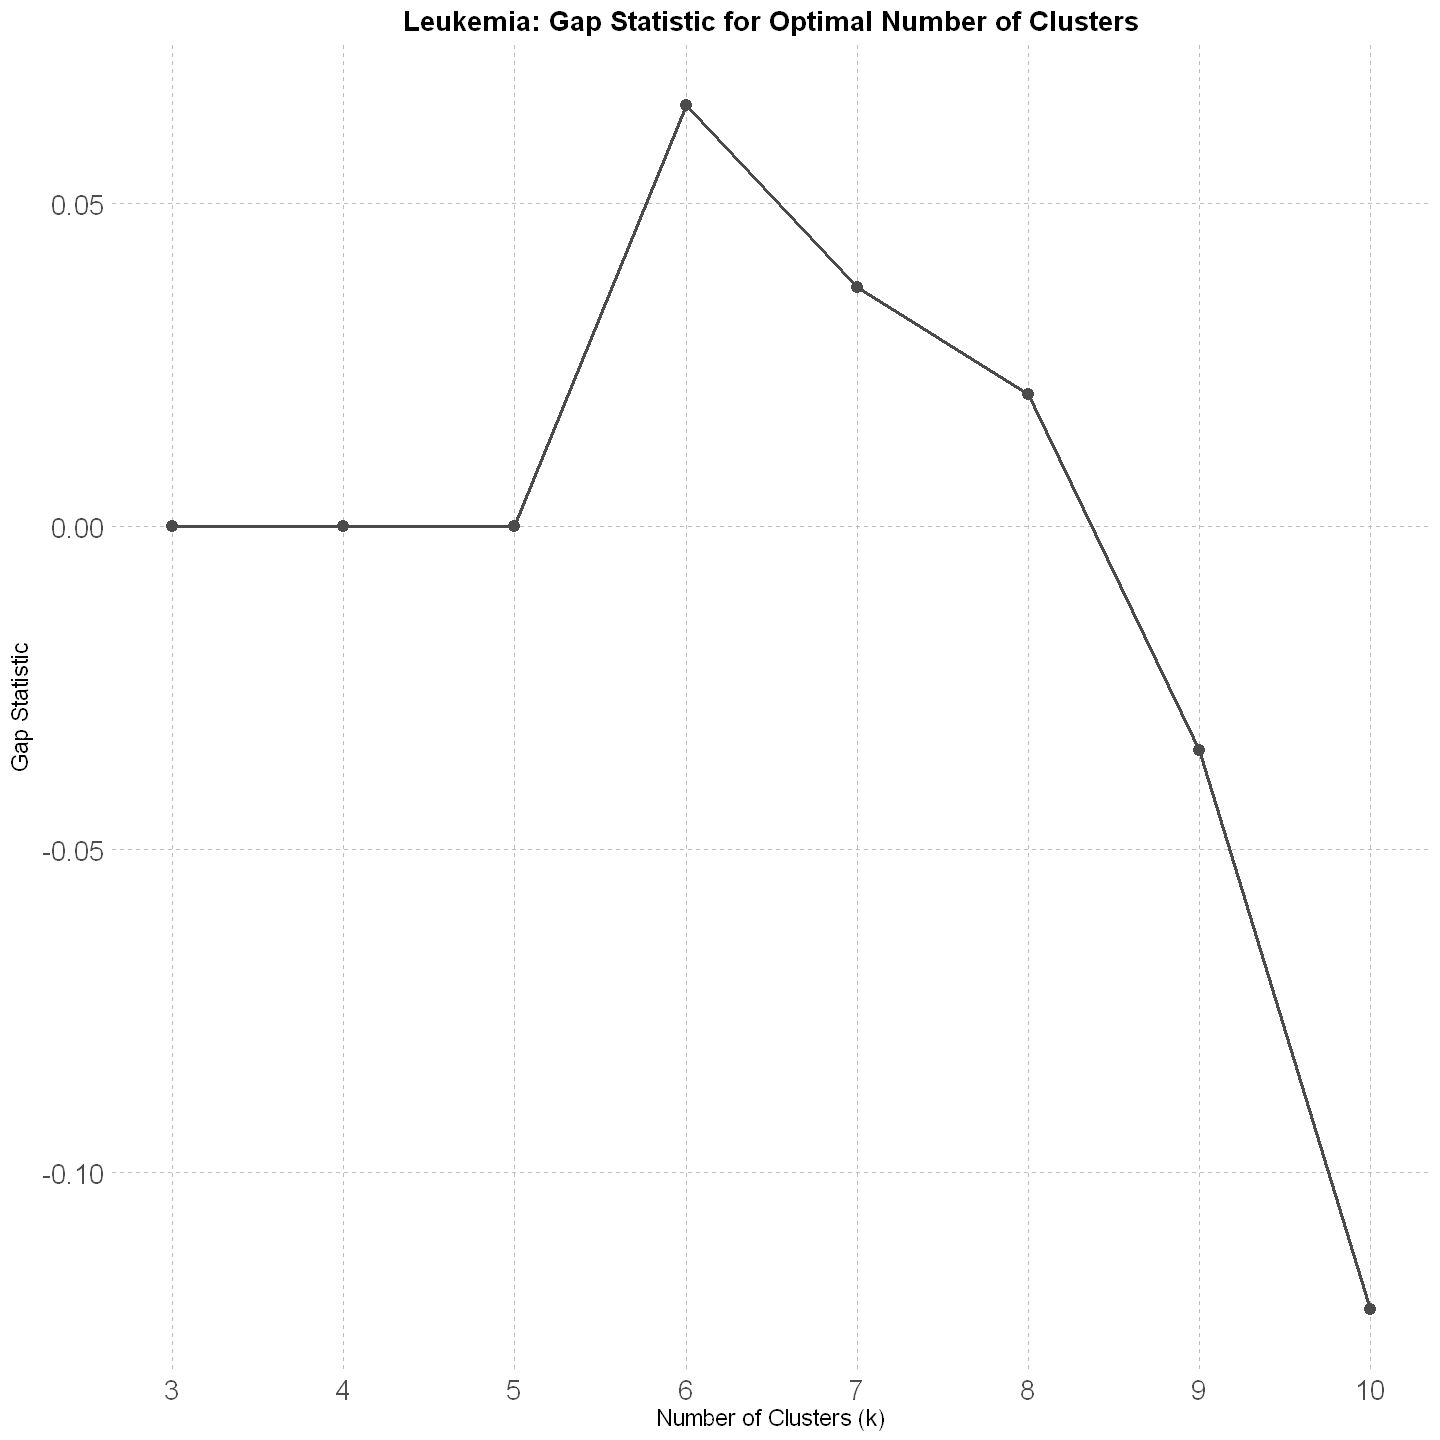

In [15]:
gap_data <- data.frame(
  k = k.range[1]:k.range[2],
  gap_stat = gap_stat
)

ggplot(gap_data, aes(x = k, y = gap_stat)) +
  geom_point(color = "#4B4B4B", size = 3) +
  geom_line(color = "#4B4B4B", size = 1) +
  #geom_hline(yintercept = max(gap_stat), color = "#E74C3C", linetype = "dashed", size = 1.2) +  # Red dashed line at max gap statistic
  #annotate("text", x = optimal_k, y = max(gap_stat), label = paste("Optimal k =", optimal_k), vjust = -0.5, color = "#E74C3C", size = 4) +  # Label for optimal k
  labs(
    title = "Leukemia: Gap Statistic for Optimal Number of Clusters",
    x = "Number of Clusters (k)",
    y = "Gap Statistic"
  ) +
  scale_x_continuous(breaks = k.range[1]:k.range[2]) +  # Set x-axis ticks to show all values in the range
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 16),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    panel.grid.minor = element_blank()
  )